# Libraries

We'll use the odbc library to connect to and query our database

In [1]:
suppressWarnings(suppressPackageStartupMessages(library(odbc)))
suppressWarnings(suppressPackageStartupMessages(library(tidyverse)))
suppressWarnings(suppressPackageStartupMessages(library(lubridate)))
suppressWarnings(suppressPackageStartupMessages(library(ggthemes)))

# Connecting to the database

Connect to the database

In [2]:
con <- dbConnect(RMySQL::MySQL(), 
          user=Sys.getenv('rds_covid_username'), 
          password=Sys.getenv('rds_covid_password'), 
          dbname='covid_data', 
          host=Sys.getenv('rds_covid_host'))

# Querying and visualizing the database

## Countries by % of vaccinated

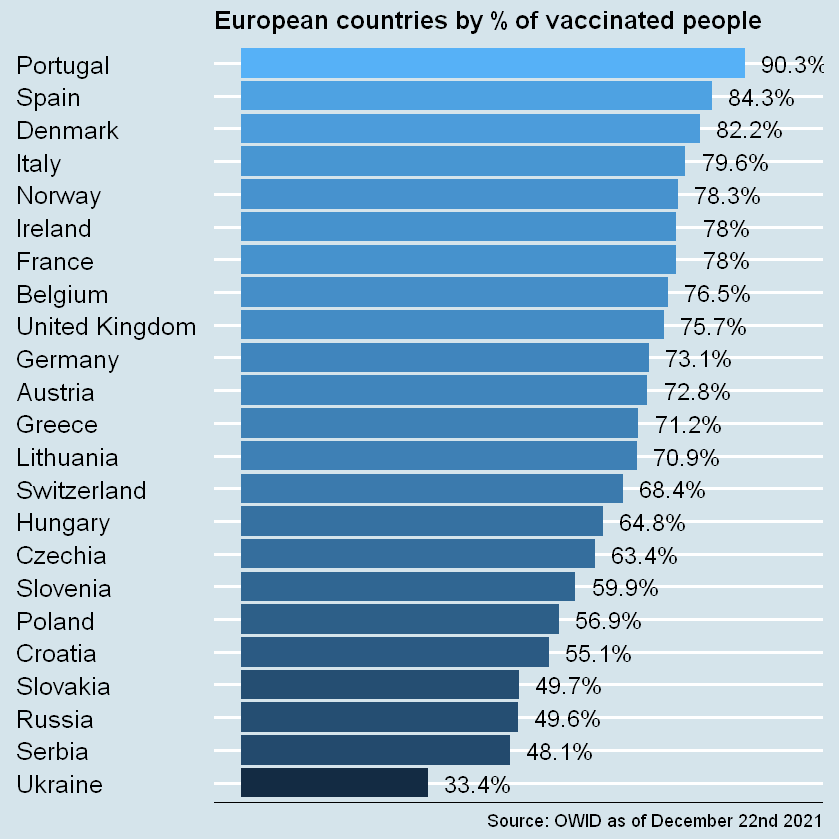

In [3]:
query <- "SELECT location, ROUND(people_vaccinated_per_hundred, 1) people_vaccinated_per_hundred
          FROM covid
          WHERE continent = 'Europe' AND 
          date = '2021-12-22' AND 
          population > 2000000 AND 
          people_vaccinated_per_hundred IS NOT NULL"

dbGetQuery(conn = con, statement = query) %>% 
ggplot(aes(x = fct_reorder(location, people_vaccinated_per_hundred), 
           y = people_vaccinated_per_hundred, 
           fill = people_vaccinated_per_hundred)) +
geom_col() +
geom_text(aes(label = paste0(people_vaccinated_per_hundred, "%")), size = 5, nudge_y = 9) +
coord_flip() +
theme_economist() +
scale_colour_gradient(low = "dark blue", high = "light blue") +
labs(title = "European countries by % of vaccinated people",
     caption = "Source: OWID as of December 22nd 2021") +
theme(plot.title = element_text(size = 15, vjust = 3),
      plot.caption = element_text(size = 11, hjust = 1, vjust = -2),
      legend.position = "none",
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.text.y = element_text(size = 15),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank())

## Correlation between vaccines and deaths

`geom_smooth()` using formula 'y ~ x'



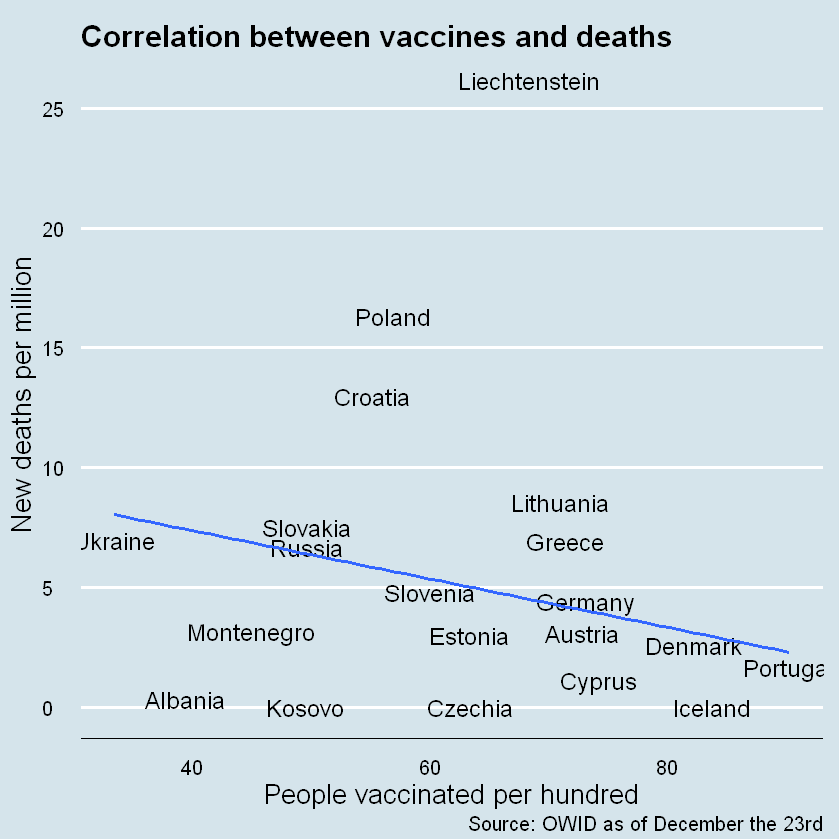

In [4]:
query <- "SELECT location, people_vaccinated_per_hundred, new_deaths_per_million
          FROM covid
          WHERE continent = 'Europe' AND
                date = '2021-12-23' AND 
                people_vaccinated_per_hundred IS NOT NULL AND
                new_deaths_per_million IS NOT NULL"

dbGetQuery(conn = con, statement = query) %>% 
ggplot(aes(x = people_vaccinated_per_hundred, y = new_deaths_per_million, label = location)) +
geom_text(size = 5, check_overlap = TRUE) +
geom_smooth(method = "lm", se = FALSE) +
scale_y_continuous(breaks = seq(0, 30, 5)) +
scale_x_continuous(breaks = seq(0, 100, 20)) +
theme_economist() +
labs(title = "Correlation between vaccines and deaths",
     #subtitle = "As of December the 23rd 2021",
     x = "People vaccinated per hundred",
     y = "New deaths per million",
     caption = "Source: OWID as of December the 23rd") +
theme(title = element_text(size = 12),
      #plot.subtitle = element_text(size = 16, hjust = 0, vjust = -2),
      plot.caption = element_text(size = 12, hjust = 1, vjust = -3),
      axis.text.x = element_text(size = 12),
      axis.title.x = element_text(size = 16, vjust = -0.5),
      axis.title.y = element_text(size = 16, vjust = 2.5),
      axis.text.y = element_text(size = 12),
      axis.ticks.x = element_blank())

## Positive rate in 2021 in Italy, France, Spain, Germany and UK

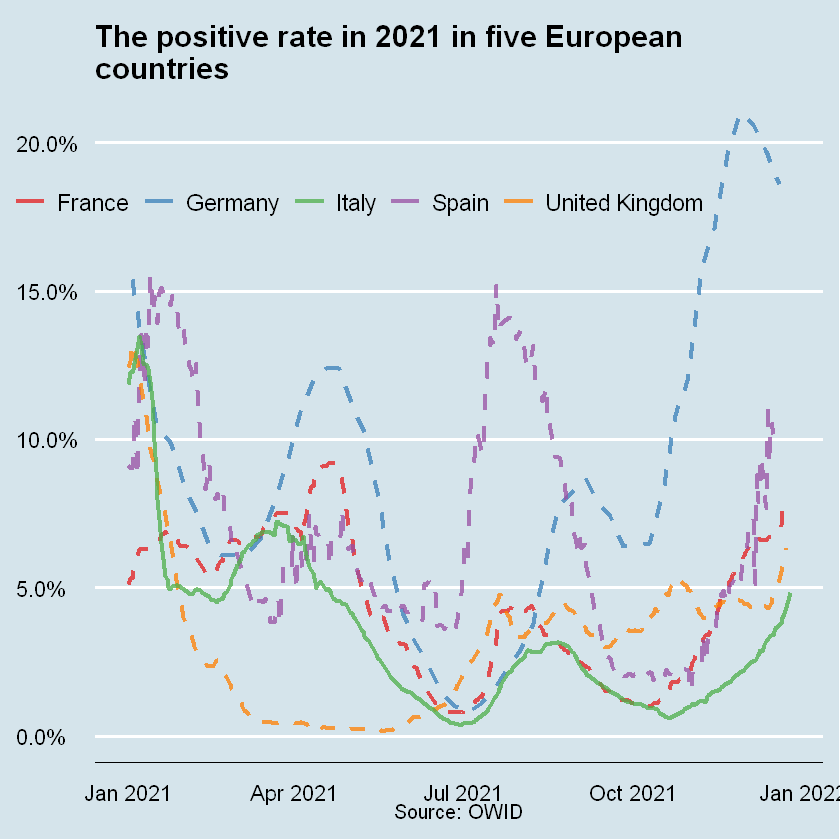

In [5]:
query <- "SELECT location, date, positive_rate
          FROM covid 
          WHERE location IN ('Italy', 'France', 'Spain', 'Germany', 'United Kingdom') 
                AND positive_rate IS NOT NULL
                AND EXTRACT(YEAR FROM CAST(date AS DATE)) = 2021"

dbGetQuery(conn = con, statement = query) %>% 
mutate(date = ymd(date),
       is_italy = if_else(location == "Italy", TRUE, FALSE)) %>% 
ggplot(aes(x = date, y = positive_rate, colour = location, label = location)) +
geom_line(aes(linetype = is_italy), size = 1.25, alpha = 0.75) +
scale_linetype_manual(values = c("dashed", "solid"), guide = "none") +
scale_y_continuous(labels = scales::percent) +
theme_economist() +
labs(title = "The positive rate in 2021 in five European\ncountries",
     caption = "Source: OWID") +
theme(#text = element_text(family = "Rubik"),
      title = element_text(size = 12),
      legend.title = element_blank(),
      legend.text = element_text(size = 14),
      legend.key.size = unit(.75, 'cm'), 
      legend.position = c(.36, .825),
      legend.direction = "horizontal",
      plot.caption = element_text(size = 12),
      axis.title.y = element_blank(),
      axis.ticks.y = element_blank(),
      axis.text.y = element_text(size = 13),
      axis.title.x = element_blank(),
      axis.ticks.x = element_blank(),
      axis.text.x = element_text(size = 13)) +
scale_colour_brewer(palette = "Set1") 

## New cases and new deaths

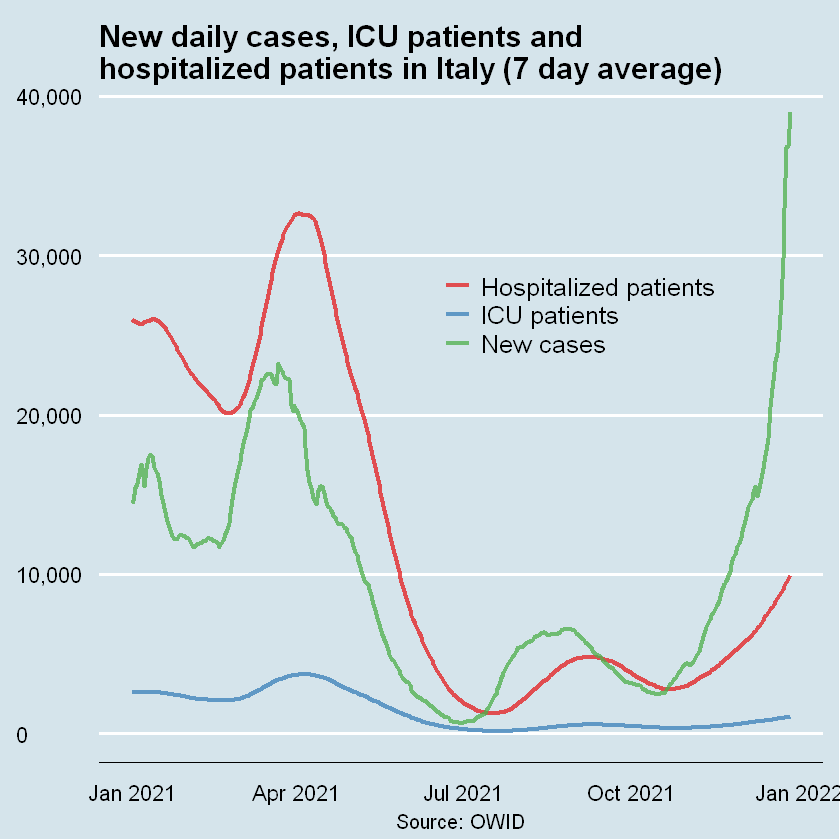

In [6]:
query <- "SELECT date,
                 EXTRACT(YEAR FROM CAST(date AS DATE)) year,
                 AVG(new_cases) OVER(PARTITION BY location ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) new_cases,
                 AVG(icu_patients) OVER(PARTITION BY location ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) icu_patients,
                 AVG(hosp_patients) OVER(PARTITION BY location ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) hosp_patients
          FROM covid
          WHERE location = 'Italy'"

dbGetQuery(conn = con, statement = query) %>% 
filter(year == 2021) %>% 
mutate(date = ymd(date)) %>% 
pivot_longer(cols = c(new_cases, icu_patients, hosp_patients), names_to = "names", values_to = "values") %>% 
ggplot(aes(x = date, y = values, colour = names)) +
geom_line(size = 1.25, alpha = 0.75) +
scale_y_continuous(labels = scales::comma) +
theme_economist() +
labs(title = "New daily cases, ICU patients and \nhospitalized patients in Italy (7 day average)",
     caption = "Source: OWID") +
theme(title = element_text(size = 12),
      legend.title = element_blank(),
      legend.text = element_text(size = 15),
      legend.position = c(.85, .75),
      legend.justification = c("right", "top"),
      legend.box.just = "right",
      legend.margin = margin(6, 6, 6, 6),
      plot.caption = element_text(size = 12, vjust = -2.5),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank(),
      axis.text.x = element_text(size = 13),
      axis.text.y = element_text(size = 13)) +
scale_color_brewer(palette = "Set1", labels = c("Hospitalized patients", "ICU patients", "New cases"))

## New deaths

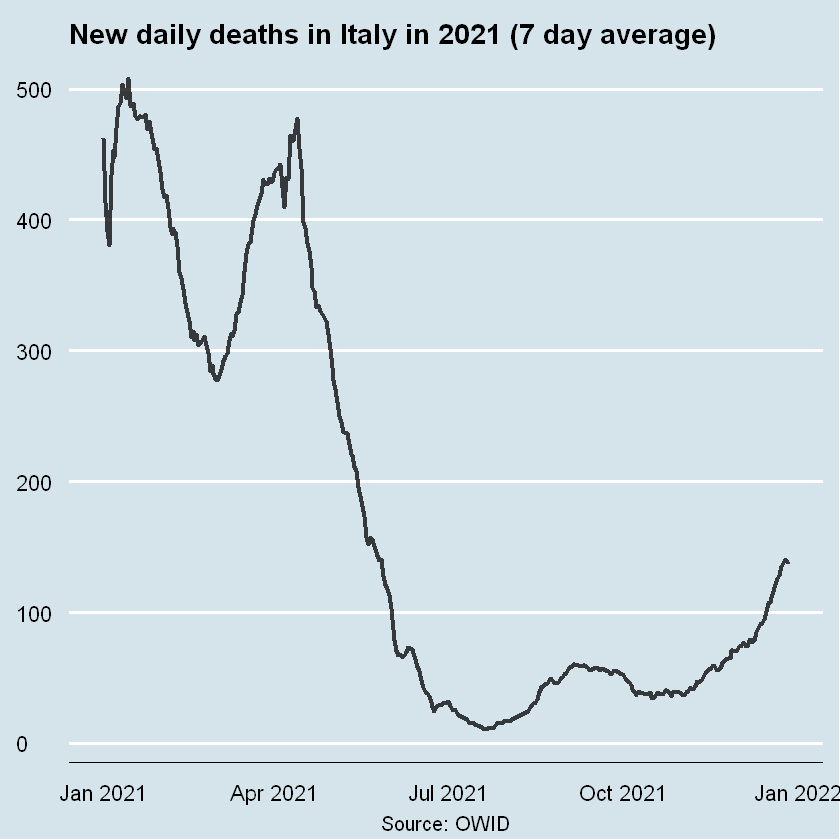

In [7]:
query <- "SELECT date, 
          AVG(new_deaths) OVER(PARTITION BY location ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) new_deaths
          FROM covid
          WHERE location = 'Italy' AND EXTRACT(YEAR FROM CAST(date AS DATE)) = 2021"

dbGetQuery(conn = con, statement = query) %>% 
mutate(date = ymd(date)) %>% 
ggplot(aes(x = date, y = new_deaths)) +
geom_line(size = 1.25, alpha = 0.75, colour = "black") +
labs(title = "New daily deaths in Italy in 2021 (7 day average)",
     caption = "Source: OWID") +
theme_economist() +
theme(axis.title.x = element_blank(),
      axis.ticks.x = element_blank(),
      axis.title.y = element_blank(),
      axis.text.x = element_text(size = 13),
      axis.text.y = element_text(size = 13),
      plot.caption = element_text(size = 12, vjust = -3))

## Total vaccinations, people vaccinated and people fully vaccinated

Warning message:
"Removed 258 row(s) containing missing values (geom_path)."


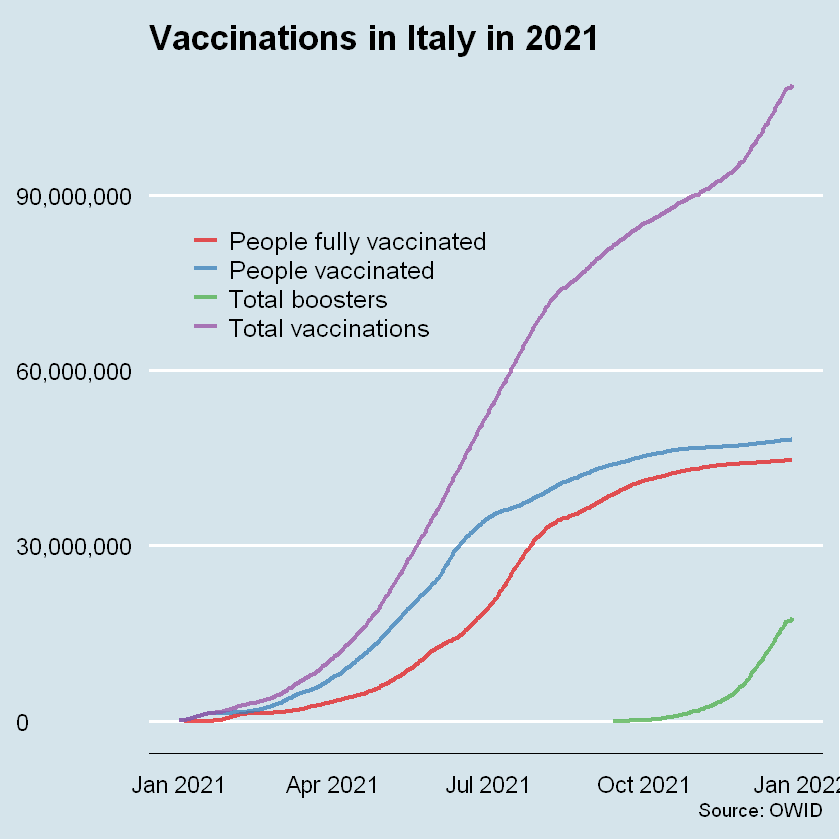

In [8]:
query <- "SELECT date,
                 total_vaccinations,
                 people_vaccinated,
                 people_fully_vaccinated,
                 total_boosters
          FROM covid
          WHERE location = 'Italy' AND
                EXTRACT(YEAR FROM date) = 2021"

dbGetQuery(conn = con, statement = query) %>% 
mutate(date = ymd(date)) %>% 
pivot_longer(cols = c(total_vaccinations, people_vaccinated, people_fully_vaccinated, total_boosters),
             names_to = "names",
             values_to = "values") %>% 
ggplot(aes(x = date, y = values, colour = names)) +
geom_line(size = 1.25, alpha = 0.75) +
theme_economist() +
scale_y_continuous(labels = scales::comma) +
labs(title = "Vaccinations in Italy in 2021",
     caption = "Source: OWID") +
theme(title = element_text(size = 14),
      axis.title.x = element_blank(),
      axis.text.x = element_text(size = 14),
      axis.ticks.x = element_blank(),
      axis.title.y = element_blank(),
      axis.ticks.y = element_blank(),
      axis.text.y = element_text(size = 14),
      legend.title = element_blank(),
      legend.text = element_text(size = 15),
      legend.position = c(.5, .78),
      legend.justification = c("right", "top"),
      legend.box.just = "right",
      legend.margin = margin(6, 6, 6, 6)) +
scale_colour_brewer(palette = "Set1", 
                    labels = c("People fully vaccinated", "People vaccinated", "Total boosters", "Total vaccinations"))

## New vaccinations

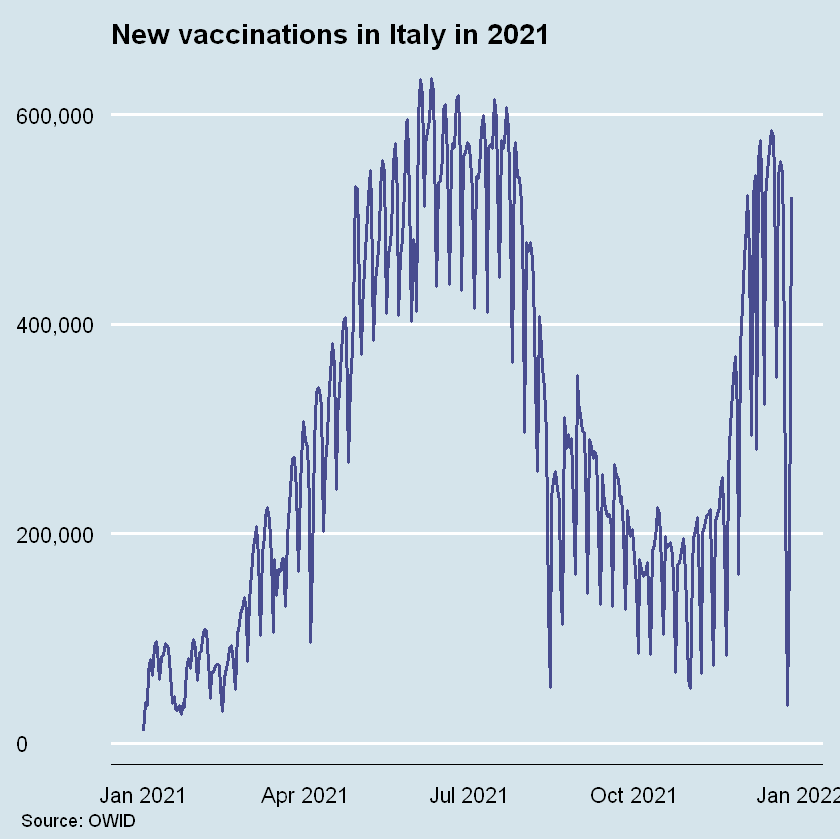

In [9]:
query <- "SELECT date,
                 new_vaccinations
          FROM covid 
          WHERE location = 'Italy' AND EXTRACT(YEAR FROM CAST(date as DATE)) = 2021"

dbGetQuery(conn = con, statement = query) %>% 
mutate(date = ymd(date))  %>% 
ggplot(aes(x = date, y = new_vaccinations)) +
geom_line(size = 1, alpha = 0.75, colour = "#191970") +
scale_y_continuous(labels = scales::comma) +
labs(title = "New vaccinations in Italy in 2021",
     caption = "Source: OWID") +
theme_economist() +
theme(legend.position = 'bottom',
      legend.title = element_blank(),
      plot.caption = element_text(size = 11, hjust = -0.15, vjust = -2),
      axis.title.x = element_blank(),
      axis.ticks.x = element_blank(),
      axis.text.x = element_text(size = 13),
      axis.title.y = element_blank(),
      axis.text.y = element_text(size = 13))

## % of vaccinated and fully vaccinated people in Italy

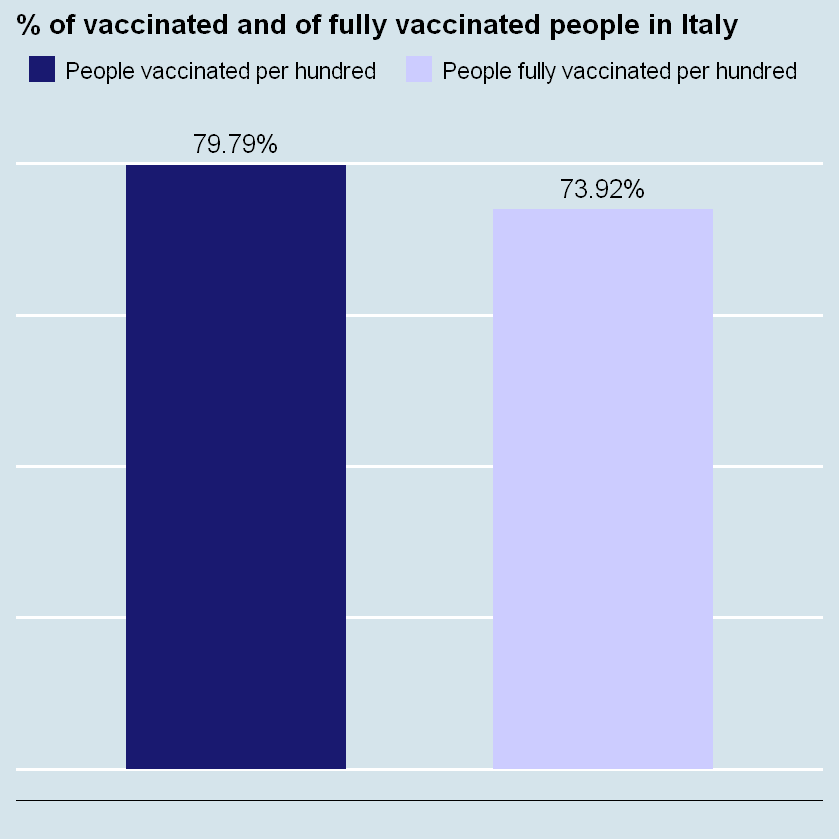

In [10]:
query  <- "SELECT people_vaccinated_per_hundred, people_fully_vaccinated_per_hundred
           FROM covid 
           WHERE location = 'Italy' AND 
           date = '2021-12-27'"

dbGetQuery(conn = con, statement = query) %>% 
pivot_longer(cols = c(people_vaccinated_per_hundred, people_fully_vaccinated_per_hundred), 
             names_to = "names", 
             values_to = "values") %>% 
ggplot(aes(x = fct_reorder(names, desc(values)), y = values, fill = names)) +
geom_col(width = 0.6) +
geom_text(aes(label = paste0(values, "%")), size = 5.5, nudge_y = 3) +
labs(title = "% of vaccinated and of fully vaccinated people in Italy",
     caption = "Source: OWID as of December the 27th") +
theme_economist() +
theme(title = element_text(vjust = 2.5),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.text.x = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks.x = element_blank(),
      plot.caption = element_text(size = 12, vjust = -1.5, hjust = 2),
      legend.title = element_blank(),
      legend.position = "top",
      legend.text = element_text(size = 14),
      legend.direction = "horizontal") +
scale_fill_manual(values = c("#191970", "#CCCCFF"),
                  limits= c("people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred"),
                  labels = c("People vaccinated per hundred", "People fully vaccinated per hundred"))